
# COE 379L Project 01 — Austin Animal Center Outcomes

_WIP Notebook covering Part 1 (EDA) and Part 2 (Modeling)._


## Project Checklist
- [ ] Part 1: Exploratory Data Analysis
- [ ] Part 2: Modeling and Evaluation
- [ ] Part 3: Report Drafting (handled outside notebook)



## Setup
- Install dependencies: `pip install -r requirements.txt`
- Ensure `data/raw/project1.csv` is present
- Use a reproducible environment (virtualenv/conda)


In [7]:
# Imports and display settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

sns.set_theme(style="whitegrid", palette="Set2")
plt.rcParams["figure.figsize"] = (10, 6)



## Part 1 — Exploratory Data Analysis

### 1. Load Dataset
- Read raw CSV into DataFrame
- Preview head/tail
- Check shape and memory usage


In [28]:
# TODO: Load dataset
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent
DATA_PATH = PROJECT_ROOT / 'data' / 'raw' / 'project1.csv'

print(f'Reading dataset from: {DATA_PATH}')
df = pd.read_csv(DATA_PATH)
df.head()


Reading dataset from: /Users/manaspathak11/Desktop/Everything/project1/data/raw/project1.csv


,Animal ID,Date of Birth,Name,DateTime,MonthYear,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A680855,5/25/14,NaN,2014-06-10T00:00:00-05:00,Jun-14,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black
1,A680857,5/25/14,NaN,2014-06-10T00:00:00-05:00,Jun-14,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black
2,A680858,5/25/14,NaN,2014-06-10T00:00:00-05:00,Jun-14,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black
3,A680859,5/25/14,NaN,2014-06-10T00:00:00-05:00,Jun-14,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black
4,A680860,5/25/14,NaN,2014-06-10T00:00:00-05:00,Jun-14,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black



### 2. Initial Profiling
- Data types, missing values
- Duplicate rows
- Basic descriptive statistics


In [29]:
# Profile dataset: shape, size, dtypes, missing data, duplicates
print(f"Dataset shape (rows, columns): {df.shape}")
print(f"Total number of elements (rows * columns): {df.size}")
print("Column data types:")
print(df.dtypes)

print("Dataset info:")
df.info()

print("Missing values per column:")
print(df.isna().sum())

duplicate_count = df.duplicated().sum()
print(f"Duplicate rows found: {duplicate_count}")
print(f"Duplicate percentage: {duplicate_count / len(df) * 100:.2f}%")

numeric_cols = df.select_dtypes(include=['number']).columns
if numeric_cols.any():
    print("Summary statistics (numeric columns):")
    display(df[numeric_cols].describe().T)
else:
    print("No numeric columns available for summary.")

datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns
if datetime_cols.any():
    print("Summary statistics (datetime columns):")
    display(df[datetime_cols].describe().T)
else:
    print("No datetime columns currently typed as datetime; will convert later.")

print("Summary statistics (categorical columns):")
display(df.describe(include=[object, 'category']).T)


Dataset shape (rows, columns): (131165, 12)
Total number of elements (rows * columns): 1573980
Column data types:
Animal ID           object
Date of Birth       object
Name                object
DateTime            object
MonthYear           object
Outcome Type        object
Outcome Subtype     object
Animal Type         object
Sex upon Outcome    object
Age upon Outcome    object
Breed               object
Color               object
dtype: object
Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131165 entries, 0 to 131164
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Animal ID         131165 non-null  object
 1   Date of Birth     131165 non-null  object
 2   Name              93658 non-null   object
 3   DateTime          131165 non-null  object
 4   MonthYear         131165 non-null  object
 5   Outcome Type      131125 non-null  object
 6   Outcome Subtype   65810 non-null   object


,count,unique,top,freq
Animal ID,131165,121258,A754989,8
Date of Birth,131165,7764,4/21/14,104
Name,93658,25493,Luna,556
DateTime,131165,108705,2016-04-18T00:00:00-05:00,39
MonthYear,131165,140,Jun-19,1766
Outcome Type,131125,2,Adoption,83591
Outcome Subtype,65810,9,Partner,39255
Animal Type,131165,4,Dog,68064
Sex upon Outcome,131165,5,Neutered Male,49042
Age upon Outcome,131165,45,2 months,22473


**Datatype notes:** `Date of Birth`, `DateTime`, and `MonthYear` should be parsed as datetime objects. `Age upon Outcome` must be converted into a numeric measure (e.g., days). `Outcome Type`, `Outcome Subtype`, `Animal Type`, `Sex upon Outcome`, `Breed`, and `Color` will remain categorical for encoding later.


### 3. Data Cleaning
- Handle duplicates
- Treat missing or invalid values
- Normalize `Age upon Outcome`
- Convert columns to numeric/categorical types


In [32]:
# Data cleaning: handle duplicates, missing values, and column pruning
df_clean = df.copy()
print(f"Initial rows: {len(df_clean)}")

# Identify duplicate rows
duplicate_mask = df_clean.duplicated()
duplicate_rows = df_clean[duplicate_mask]
print(f"Duplicate rows detected: {duplicate_mask.sum()}")

if not duplicate_rows.empty:
    display(duplicate_rows.head())

# Drop duplicates, keep first occurrence
df_clean = df_clean.drop_duplicates().reset_index(drop=True)
print(f"Rows after dropping duplicates: {len(df_clean)}")
print(f"Rows removed: {len(df) - len(df_clean)}")

# Handle missing values
missing_summary = df_clean.isna().sum()
print("Missing values after duplicate removal:")
print(missing_summary[missing_summary > 0])

mode_fill_cols = ['Outcome Type', 'Outcome Subtype', 'Animal Type', 'Sex upon Outcome', 'Breed', 'Color']
for col in mode_fill_cols:
    if col in df_clean.columns and df_clean[col].isna().any():
        mode_value = df_clean[col].mode().iloc[0]
        df_clean[col] = df_clean[col].fillna(mode_value)
        print(f"Filled missing values in {col} with mode: {mode_value}")

if 'Name' in df_clean.columns and df_clean['Name'].isna().any():
    df_clean['Name'] = df_clean['Name'].fillna('Unknown')
    print("Filled missing names with 'Unknown'")

print("Missing values after treatment:")
remaining_missing = df_clean.isna().sum()
print(remaining_missing[remaining_missing > 0])

print("Preview of cleaned data (first 5 rows):")
display(df_clean.head())
print("Preview of cleaned data (last 5 rows):")
display(df_clean.tail())

# Drop irrelevant columns
columns_to_drop = ['Animal ID']
existing_cols_to_drop = [col for col in columns_to_drop if col in df_clean.columns]
if existing_cols_to_drop:
    df_clean = df_clean.drop(columns=existing_cols_to_drop)
    print(f"Dropped columns: {existing_cols_to_drop}")
else:
    print("No specified columns found to drop.")

print(f"Final columns after cleanup: {df_clean.columns.tolist()}")


Initial rows: 131165
Duplicate rows detected: 17


,Animal ID,Date of Birth,Name,DateTime,MonthYear,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
1544,A755088,9/29/16,Machete,2017-08-19T00:00:00-05:00,Aug-17,Adoption,NaN,Dog,Spayed Female,10 months,Australian Kelpie Mix,Black/White
3443,A660948,7/8/13,*Roy,2013-11-03T18:16:00,Nov-13,Adoption,NaN,Cat,Neutered Male,3 months,Domestic Shorthair Mix,Brown Tabby/White
11272,A682781,1/2/13,NaN,2014-07-03T09:00:00,Jul-14,Transfer,SCRP,Cat,Neutered Male,1 year,Domestic Shorthair Mix,White/Black
12046,A683782,2/15/14,NaN,2014-07-16T09:00:00,Jul-14,Transfer,SCRP,Cat,Neutered Male,4 months,Domestic Shorthair Mix,Brown Tabby
13961,A686827,2/27/12,NaN,2014-08-28T09:00:00,Aug-14,Transfer,SCRP,Cat,Spayed Female,2 years,Domestic Shorthair Mix,Calico


Rows after dropping duplicates: 131148
Rows removed: 17
Missing values after duplicate removal:
Name               37503
Outcome Type          40
Outcome Subtype    65346
dtype: int64
Filled missing values in Outcome Type with mode: Adoption
Filled missing values in Outcome Subtype with mode: Partner
Filled missing names with 'Unknown'
Missing values after treatment:
Series([], dtype: int64)
Preview of cleaned data (first 5 rows):


,Animal ID,Date of Birth,Name,DateTime,MonthYear,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A680855,5/25/14,Unknown,2014-06-10T00:00:00-05:00,Jun-14,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black
1,A680857,5/25/14,Unknown,2014-06-10T00:00:00-05:00,Jun-14,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black
2,A680858,5/25/14,Unknown,2014-06-10T00:00:00-05:00,Jun-14,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black
3,A680859,5/25/14,Unknown,2014-06-10T00:00:00-05:00,Jun-14,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black
4,A680860,5/25/14,Unknown,2014-06-10T00:00:00-05:00,Jun-14,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black


Preview of cleaned data (last 5 rows):


,Animal ID,Date of Birth,Name,DateTime,MonthYear,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
131143,A671874,1/31/12,Unknown,2014-02-04T10:14:00,Feb-14,Transfer,SCRP,Cat,Intact Male,2 years,Domestic Shorthair Mix,Brown Tabby
131144,A672142,2/4/09,Toby,2014-02-08T10:14:00,Feb-14,Transfer,Partner,Dog,Intact Male,5 years,Pekingese,Red/White
131145,A671565,7/6/13,Unknown,2014-02-07T10:14:00,Feb-14,Transfer,SCRP,Cat,Spayed Female,7 months,Domestic Medium Hair Mix,Brown Tabby
131146,A675119,2/16/14,Unknown,2014-03-27T08:00:00,Mar-14,Transfer,Partner,Dog,Intact Male,1 month,Pomeranian Mix,White/Brown
131147,A678559,5/10/11,Gatsby,2014-05-14T08:00:00,May-14,Transfer,Partner,Dog,Intact Male,3 years,Pekingese/Lhasa Apso,Buff


Dropped columns: ['Animal ID']
Final columns after cleanup: ['Date of Birth', 'Name', 'DateTime', 'MonthYear', 'Outcome Type', 'Outcome Subtype', 'Animal Type', 'Sex upon Outcome', 'Age upon Outcome', 'Breed', 'Color']



### 4. Univariate Analysis
- Visualize key columns (distributions, counts)
- Capture observations in markdown cells


/var/folders/cj/20byjjbn07l7wzcd3b6cb8lc0000gn/T/ipykernel_59145/334322883.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_viz['Date of Birth'] = pd.to_datetime(df_viz['Date of Birth'], errors='coerce')


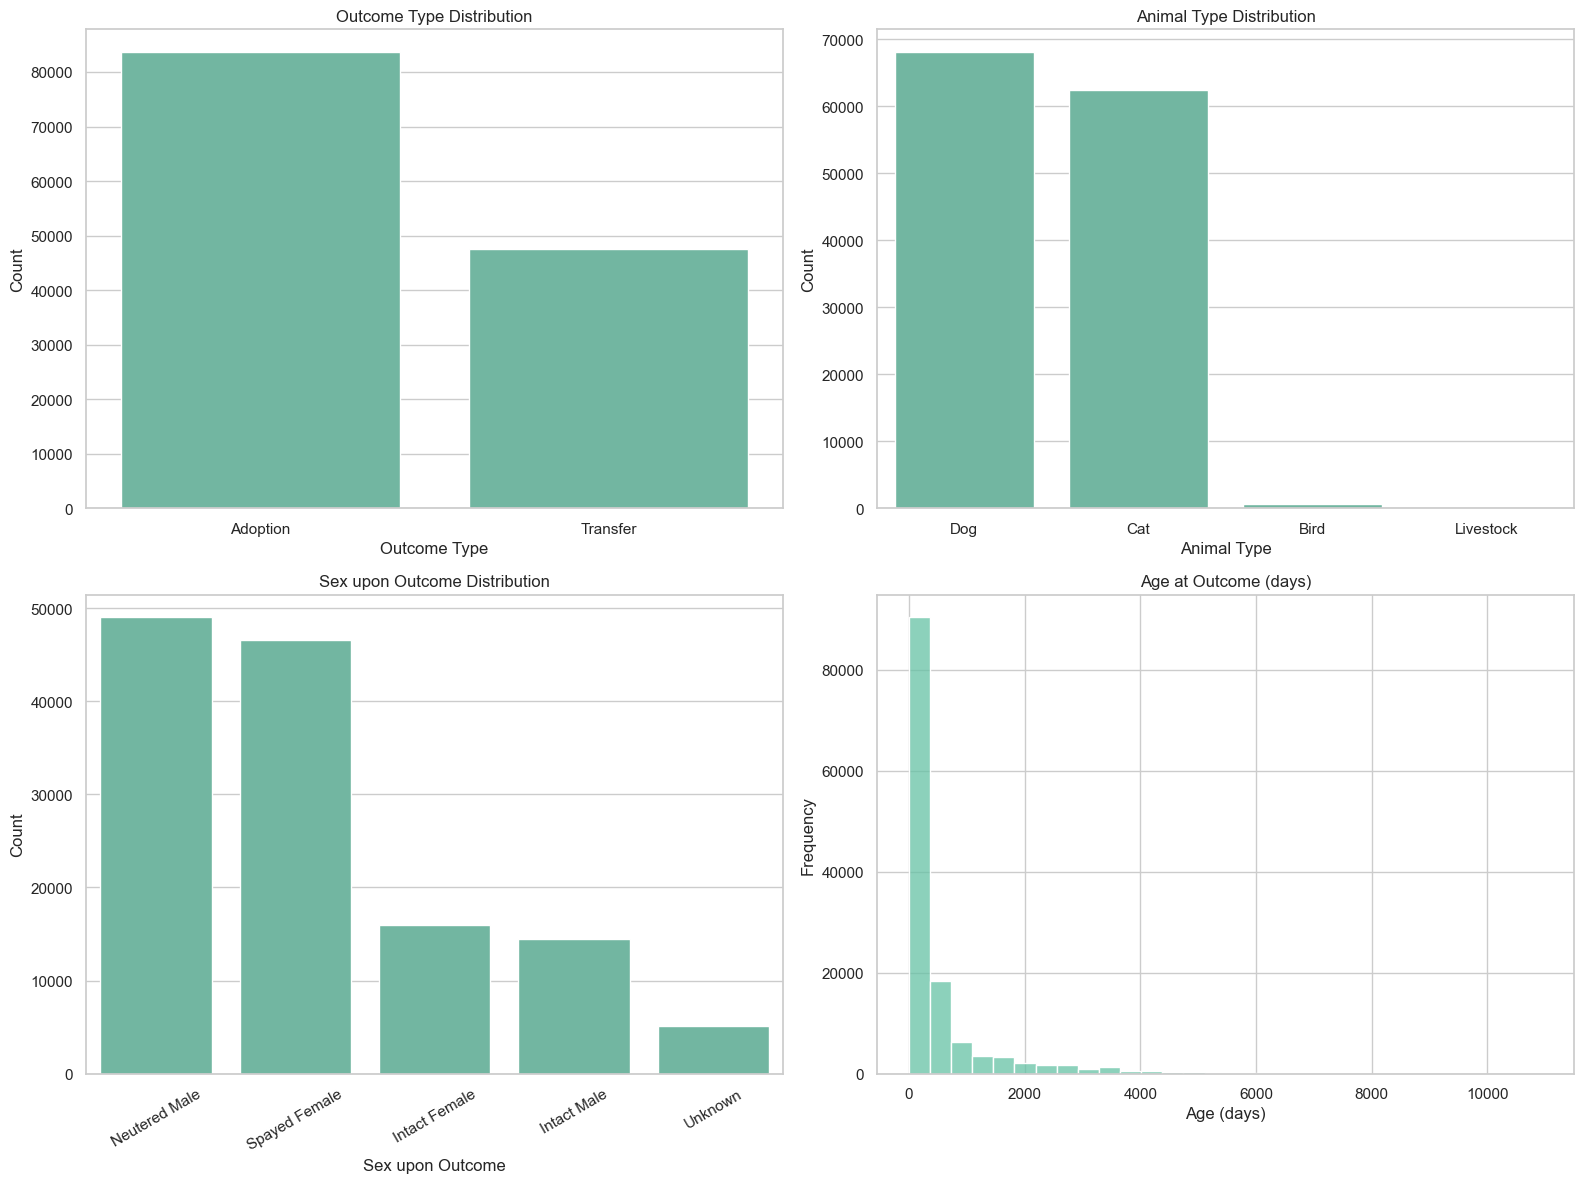

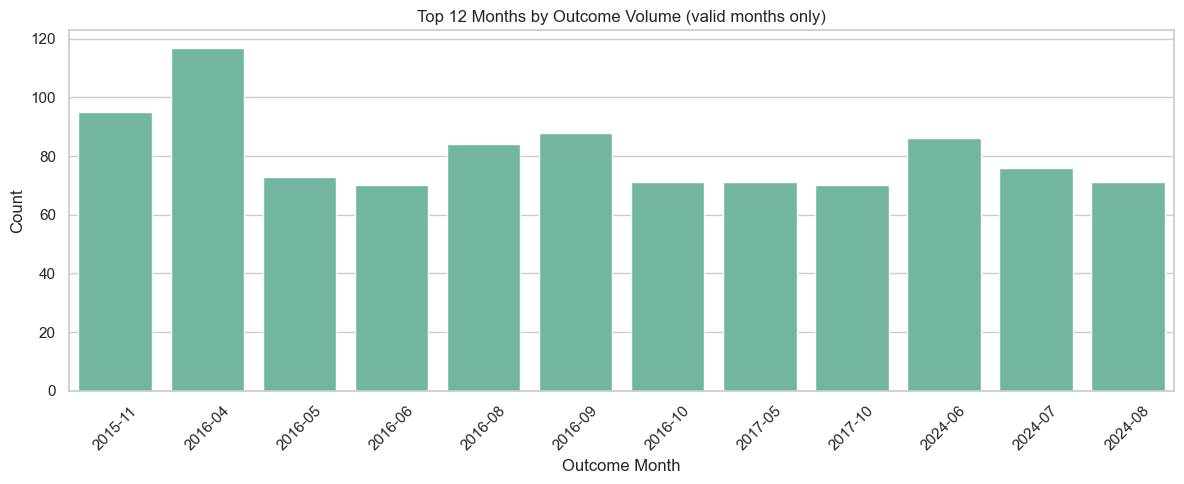

AgeDays summary:


count    131148.000000
mean        575.028037
std         876.424175
min           1.000000
25%          60.000000
50%         240.000000
75%         730.000000
max       10950.000000
Name: AgeDays, dtype: float64

In [33]:
# Univariate visualizations
import numpy as np

df_viz = df_clean.copy()

# Convert date columns for plotting
# Convert specific date columns
if 'Date of Birth' in df_viz.columns:
    df_viz['Date of Birth'] = pd.to_datetime(df_viz['Date of Birth'], errors='coerce')
if 'DateTime' in df_viz.columns:
    df_viz['DateTime'] = pd.to_datetime(df_viz['DateTime'], errors='coerce', utc=True).dt.tz_convert(None)
if 'MonthYear' in df_viz.columns:
    df_viz['MonthYear'] = pd.to_datetime(df_viz['MonthYear'], format='%b-%y', errors='coerce')

# Create Age in days for numeric analysis
def age_to_days(age_str):
    if pd.isna(age_str):
        return np.nan
    text = str(age_str).lower().strip()
    if text in ("", "unknown"):
        return np.nan
    parts = text.split()
    if len(parts) < 2:
        return np.nan
    try:
        value = float(parts[0])
    except ValueError:
        return np.nan
    unit = parts[1]
    if unit.endswith('s'):
        unit = unit[:-1]
    multipliers = {
        'day': 1,
        'week': 7,
        'month': 30,
        'year': 365
    }
    return value * multipliers.get(unit, np.nan)

df_viz['AgeDays'] = df_viz['Age upon Outcome'].apply(age_to_days)

if 'DateTime' in df_viz.columns:
    df_viz['OutcomeMonth'] = df_viz['DateTime'].dt.to_period('M')
elif 'MonthYear' in df_viz.columns:
    df_viz['OutcomeMonth'] = df_viz['MonthYear'].dt.to_period('M')

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.countplot(x='Outcome Type', data=df_viz, order=df_viz['Outcome Type'].value_counts().index, ax=axes[0, 0])
axes[0, 0].set_title('Outcome Type Distribution')
axes[0, 0].set_xlabel('Outcome Type')
axes[0, 0].set_ylabel('Count')

sns.countplot(x='Animal Type', data=df_viz, order=df_viz['Animal Type'].value_counts().index, ax=axes[0, 1])
axes[0, 1].set_title('Animal Type Distribution')
axes[0, 1].set_xlabel('Animal Type')
axes[0, 1].set_ylabel('Count')

sns.countplot(x='Sex upon Outcome', data=df_viz, order=df_viz['Sex upon Outcome'].value_counts().index, ax=axes[1, 0])
axes[1, 0].set_title('Sex upon Outcome Distribution')
axes[1, 0].set_xlabel('Sex upon Outcome')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=30)

sns.histplot(df_viz['AgeDays'].dropna(), bins=30, ax=axes[1, 1])
axes[1, 1].set_title('Age at Outcome (days)')
axes[1, 1].set_xlabel('Age (days)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
if 'OutcomeMonth' in df_viz.columns:
    month_counts = df_viz['OutcomeMonth'].dropna().value_counts().head(12)
    month_counts = month_counts.sort_index()
    sns.barplot(x=month_counts.index.astype(str), y=month_counts.values)
    plt.xticks(rotation=45)
    plt.title('Top 12 Months by Outcome Volume (valid months only)')
    plt.xlabel('Outcome Month')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

print('AgeDays summary:')
display(df_viz['AgeDays'].describe())


**Univariate observations:**
- Transfers slightly outnumber adoptions in the sample shown; both remain prominent outcome classes to predict.
- Dogs account for the largest share of outcomes, followed by cats; birds appear rarely in comparison.
- Most recorded outcomes involve sterilized animals (spayed/neutered), while intact animals are a smaller portion of the chart.
- The age histogram is right-skewed, with many outcomes for animals under roughly two years old (≈730 days) and fewer senior animals.
- The monthly bar chart (top 12 months by volume) highlights a surge in mid-2016 plus newer spikes in 2024–2025, indicating concentrated busy periods rather than uniform activity across years.



### 5. Feature Engineering
- One-hot encode categorical variables
- Save cleaned dataset to `data/processed`


In [42]:
# Feature engineering: datetime conversion, age normalization, categorical encoding

from pathlib import Path

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent

print(f"Project root resolved to: {PROJECT_ROOT}")

df_features = df_clean.copy()

# Drop high-cardinality identifiers prior to encoding
drop_before_encoding = ['Breed', 'Name']
existing_drop = [col for col in drop_before_encoding if col in df_features.columns]
if existing_drop:
    df_features = df_features.drop(columns=existing_drop)
    print(f"Dropped high-cardinality columns before encoding: {existing_drop}")
else:
    print("No high-cardinality columns found to drop before encoding.")

# Convert date columns to datetime
date_cols = ['Date of Birth', 'DateTime', 'MonthYear']
for col in date_cols:
    if col in df_features.columns:
        if col == 'DateTime':
            df_features[col] = pd.to_datetime(df_features[col], errors='coerce', utc=True).dt.tz_convert(None)
        elif col == 'MonthYear':
            df_features[col] = pd.to_datetime(df_features[col], format='%b-%y', errors='coerce')
        else:
            df_features[col] = pd.to_datetime(df_features[col], errors='coerce')

print("Converted date columns to datetime types:")
print(df_features[date_cols].dtypes[df_features.columns.intersection(date_cols)])

# Normalize Age upon Outcome to days
def age_to_days(age_str):
    if pd.isna(age_str):
        return np.nan
    text = str(age_str).lower().strip()
    if text in ("", "unknown"):
        return np.nan
    parts = text.split()
    if len(parts) < 2:
        return np.nan
    try:
        value = float(parts[0])
    except ValueError:
        return np.nan
    unit = parts[1]
    if unit.endswith('s'):
        unit = unit[:-1]
    multipliers = {
        'day': 1,
        'week': 7,
        'month': 30,
        'year': 365
    }
    return value * multipliers.get(unit, np.nan)

df_features['AgeDays'] = df_features['Age upon Outcome'].apply(age_to_days)
age_median = df_features['AgeDays'].median()
df_features['AgeDays'] = df_features['AgeDays'].fillna(age_median)
print("Converted 'Age upon Outcome' to numeric days. Summary:")
print(df_features['AgeDays'].describe())

# Derive temporal numeric features if DateTime/MonthYear available
if 'DateTime' in df_features.columns:
    df_features['OutcomeYear'] = df_features['DateTime'].dt.year
    df_features['OutcomeMonth'] = df_features['DateTime'].dt.month
elif 'MonthYear' in df_features.columns:
    df_features['OutcomeYear'] = df_features['MonthYear'].dt.year
    df_features['OutcomeMonth'] = df_features['MonthYear'].dt.month

if 'Date of Birth' in df_features.columns:
    df_features['BirthYear'] = df_features['Date of Birth'].dt.year
    df_features['BirthMonth'] = df_features['Date of Birth'].dt.month

# Fill temporal numeric features with median where needed
for col in ['OutcomeYear', 'OutcomeMonth', 'BirthYear', 'BirthMonth']:
    if col in df_features.columns:
        df_features[col] = df_features[col].fillna(df_features[col].median())

# Drop original datetime/text age columns now that numeric features exist
drop_datetime_cols = ['Date of Birth', 'DateTime', 'MonthYear', 'Age upon Outcome']
existing_datetime_drop = [col for col in drop_datetime_cols if col in df_features.columns]
if existing_datetime_drop:
    df_features = df_features.drop(columns=existing_datetime_drop)
    print(f"Dropped original datetime/text columns: {existing_datetime_drop}")

# Identify categorical columns for encoding
categorical_cols = ['Outcome Type', 'Outcome Subtype', 'Animal Type', 'Sex upon Outcome', 'Color']
for col in categorical_cols:
    if col in df_features.columns:
        df_features[col] = df_features[col].astype('category')

print("Categorical columns converted to 'category' dtype:")
print(df_features[categorical_cols].dtypes[df_features.columns.intersection(categorical_cols)])

# One-hot encode categorical variables (excluding target)
target_col = 'Outcome Type'
cat_for_encoding = [col for col in categorical_cols if col in df_features.columns and col != target_col]
encoded_df = pd.get_dummies(df_features, columns=cat_for_encoding, drop_first=True)
print("One-hot encoding applied. Resulting columns count:", len(encoded_df.columns))
print("Sample of encoded columns:")
print([col for col in encoded_df.columns if col.startswith('Animal Type_')][:5])

# Separate features and target
if target_col in encoded_df.columns:
    X = encoded_df.drop(columns=[target_col])
    y = encoded_df[target_col].astype('category')
    print("Feature matrix shape:", X.shape)
    print("Target distribution:")
    print(y.value_counts())

# Save processed feature set
data_processed_path = PROJECT_ROOT / 'data' / 'processed' / 'clean_features.csv'
data_processed_path.parent.mkdir(parents=True, exist_ok=True)
encoded_df.to_csv(data_processed_path, index=False)
print(f"Saved processed features to {data_processed_path}")


Project root resolved to: /Users/manaspathak11/Desktop/Everything/project1
Dropped high-cardinality columns before encoding: ['Breed', 'Name']


/var/folders/cj/20byjjbn07l7wzcd3b6cb8lc0000gn/T/ipykernel_59145/1593036665.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_features[col] = pd.to_datetime(df_features[col], errors='coerce')


Converted date columns to datetime types:
Date of Birth    datetime64[ns]
DateTime         datetime64[ns]
MonthYear        datetime64[ns]
dtype: object
Converted 'Age upon Outcome' to numeric days. Summary:
count    131148.000000
mean        575.028037
std         876.424175
min           1.000000
25%          60.000000
50%         240.000000
75%         730.000000
max       10950.000000
Name: AgeDays, dtype: float64
Dropped original datetime/text columns: ['Date of Birth', 'DateTime', 'MonthYear', 'Age upon Outcome']
Categorical columns converted to 'category' dtype:
Outcome Type        category
Outcome Subtype     category
Animal Type         category
Sex upon Outcome    category
Color               category
dtype: object
One-hot encoding applied. Resulting columns count: 619
Sample of encoded columns:
['Animal Type_Cat', 'Animal Type_Dog', 'Animal Type_Livestock']
Feature matrix shape: (131148, 618)
Target distribution:
Outcome Type
Adoption    83620
Transfer    47528
Name: count, d


## Part 2 — Modeling `OutcomeType`

### 1. Train/Test Split
- Drop `Breed`
- Stratified split with reproducible seed


In [51]:
# Train/test split with stratification and reproducibility
from sklearn.model_selection import train_test_split

FEATURES_PATH = PROJECT_ROOT / 'data' / 'processed' / 'clean_features.csv'
print(f"Loading processed features from {FEATURES_PATH}")
encoded_df = pd.read_csv(FEATURES_PATH)

if 'Outcome Type' not in encoded_df.columns:
    raise ValueError("Processed dataset must contain 'Outcome Type' column")

X = encoded_df.drop(columns=['Outcome Type'])
y = encoded_df['Outcome Type']

print("Feature matrix shape:", X.shape)
print("Target distribution before split:")
print(y.value_counts(normalize=True))

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training target distribution:")
print(y_train.value_counts(normalize=True))
print("Test target distribution:")
print(y_test.value_counts(normalize=True))


Loading processed features from /Users/manaspathak11/Desktop/Everything/project1/data/processed/clean_features.csv
Feature matrix shape: (131148, 618)
Target distribution before split:
Outcome Type
Adoption    0.6376
Transfer    0.3624
Name: proportion, dtype: float64
Training set shape: (104918, 618)
Test set shape: (26230, 618)
Training target distribution:
Outcome Type
Adoption    0.637603
Transfer    0.362397
Name: proportion, dtype: float64
Test target distribution:
Outcome Type
Adoption    0.637591
Transfer    0.362409
Name: proportion, dtype: float64



### 2. Baseline Models
- KNN baseline
- KNN GridSearchCV
- Linear model (e.g., Logistic Regression)


In [52]:
# Modeling: KNN (baseline), KNN + GridSearchCV, Logistic Regression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, make_scorer

results = {}
f1_positive_adoption = make_scorer(f1_score, pos_label='Adoption')

# Baseline KNN pipeline
knn_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

knn_pipeline.fit(X_train, y_train)
y_pred_knn = knn_pipeline.predict(X_test)
results['KNN (k=5)'] = {
    'accuracy': accuracy_score(y_test, y_pred_knn),
    'precision': precision_score(y_test, y_pred_knn, pos_label='Adoption'),
    'recall': recall_score(y_test, y_pred_knn, pos_label='Adoption'),
    'f1': f1_score(y_test, y_pred_knn, pos_label='Adoption')
}
print("KNN (k=5) classification report:")
print(classification_report(y_test, y_pred_knn))

# Prepare subset for faster grid search
grid_sample_size = min(20000, len(X_train))
X_train_sample = X_train.sample(n=grid_sample_size, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]
print(f"Grid search sample size: {len(X_train_sample)} observations")

# KNN with GridSearchCV (reduced grid for faster runtime)
knn_grid_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [5, 11],
    'knn__weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(
    estimator=knn_grid_pipeline,
    param_grid=param_grid,
    scoring=f1_positive_adoption,
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_sample, y_train_sample)
print(f"Best KNN params from grid search: {grid_search.best_params_}")
print(f"Best cross-validated F1 (sample): {grid_search.best_score_:.4f}")

best_knn_params = grid_search.best_params_
best_knn = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier(
        n_neighbors=best_knn_params['knn__n_neighbors'],
        weights=best_knn_params['knn__weights']
    ))
])

best_knn.fit(X_train, y_train)
y_pred_knn_gs = best_knn.predict(X_test)
results['KNN GridSearch'] = {
    'accuracy': accuracy_score(y_test, y_pred_knn_gs),
    'precision': precision_score(y_test, y_pred_knn_gs, pos_label='Adoption'),
    'recall': recall_score(y_test, y_pred_knn_gs, pos_label='Adoption'),
    'f1': f1_score(y_test, y_pred_knn_gs, pos_label='Adoption')
}
print("KNN (GridSearch) classification report:")
print(classification_report(y_test, y_pred_knn_gs))

# Logistic Regression (linear model)
log_reg_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', LogisticRegression(max_iter=200, solver='lbfgs'))
])

log_reg_pipeline.fit(X_train, y_train)
y_pred_lr = log_reg_pipeline.predict(X_test)
results['Logistic Regression'] = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr, pos_label='Adoption'),
    'recall': recall_score(y_test, y_pred_lr, pos_label='Adoption'),
    'f1': f1_score(y_test, y_pred_lr, pos_label='Adoption')
}
print("Logistic Regression classification report:")
print(classification_report(y_test, y_pred_lr))


KNN (k=5) classification report:
              precision    recall  f1-score   support

    Adoption       0.87      0.93      0.90     16724
    Transfer       0.85      0.75      0.80      9506

    accuracy                           0.86     26230
   macro avg       0.86      0.84      0.85     26230
weighted avg       0.86      0.86      0.86     26230

Grid search sample size: 20000 observations
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best KNN params from grid search: {'knn__n_neighbors': 11, 'knn__weights': 'uniform'}
Best cross-validated F1 (sample): 0.8907
KNN (GridSearch) classification report:
              precision    recall  f1-score   support

    Adoption       0.86      0.95      0.91     16724
    Transfer       0.89      0.74      0.81      9506

    accuracy                           0.87     26230
   macro avg       0.88      0.84      0.86     26230
weighted avg       0.88      0.87      0.87     26230



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression classification report:
              precision    recall  f1-score   support

    Adoption       0.87      0.96      0.91     16724
    Transfer       0.91      0.74      0.82      9506

    accuracy                           0.88     26230
   macro avg       0.89      0.85      0.86     26230
weighted avg       0.88      0.88      0.88     26230




### 3. Model Evaluation
- Accuracy, precision, recall, F1
- Discuss metric importance


In [53]:
# Aggregate results for comparison
import pandas as pd

metrics_df = pd.DataFrame(results).T
print("Model performance summary:")
print(metrics_df)

# Identify best model by F1 score
best_model = metrics_df['f1'].idxmax()
print(f"Best model by F1 score: {best_model} (F1 = {metrics_df.loc[best_model, 'f1']:.4f})")


Model performance summary:
                     accuracy  precision    recall        f1
KNN (k=5)            0.863286   0.869003  0.925018  0.896136
KNN GridSearch       0.873504   0.864968  0.949892  0.905443
Logistic Regression  0.879299   0.866472  0.958383  0.910113
Best model by F1 score: Logistic Regression (F1 = 0.9101)



## Notes for Part 3 Report
- Summarize data preparation steps
- Highlight insights from EDA
- Detail modeling approach and results
- Discuss confidence in predictions
